In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

%matplotlib inline
%config InlineBackend.figure_format='retina'

pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)

import warnings
warnings.filterwarnings('ignore')

## Logistic regression from scratch and simple comparison of accuracy with Tensorflow:

### Load file and add columns header:

In [2]:
columns = ['Pregnancies','Glucose','BloodPressure','SkinThickness','Insulin',
           'BMI','DiabetesPedigreeFunction','Age','Class']

df = pd.read_csv('pima-indians-diabetes.csv',header=None,names=columns)
print('rows:',df.shape[0],'columns:',df.shape[1])
df.head(3)

rows: 768 columns: 9


Pregnancies  Glucose  BloodPressure  SkinThickness  Insulin   BMI  \
0            6      148             72             35        0  33.6   
1            1       85             66             29        0  26.6   
2            8      183             64              0        0  23.3   

   DiabetesPedigreeFunction  Age  Class  
0                     0.627   50      1  
1                     0.351   31      0  
2                     0.672   32      1

### About this dataset:

Several constraints were placed on the selection of these instances from a larger database. All patients here are females at least 21 years old of Pima Indian heritage.

#### Attribute Information:

- Number of times pregnant
- Plasma glucose concentration a 2 hours in an oral glucose tolerance test
- Diastolic blood pressure (mm Hg)
- Triceps skin fold thickness (mm)
- 2-Hour serum insulin (mu U/ml)
- Body Mass Index (weight in kg/(height in m)^2)
- Diabetes pedigree function
- Age in years
- Class variable (0 or 1)

In [3]:
df.describe().T

count        mean         std     min       25%  \
Pregnancies               768.0    3.845052    3.369578   0.000   1.00000   
Glucose                   768.0  120.894531   31.972618   0.000  99.00000   
BloodPressure             768.0   69.105469   19.355807   0.000  62.00000   
SkinThickness             768.0   20.536458   15.952218   0.000   0.00000   
Insulin                   768.0   79.799479  115.244002   0.000   0.00000   
BMI                       768.0   31.992578    7.884160   0.000  27.30000   
DiabetesPedigreeFunction  768.0    0.471876    0.331329   0.078   0.24375   
Age                       768.0   33.240885   11.760232  21.000  24.00000   
Class                     768.0    0.348958    0.476951   0.000   0.00000   

                               50%        75%     max  
Pregnancies                 3.0000    6.00000   17.00  
Glucose                   117.0000  140.25000  199.00  
BloodPressure              72.0000   80.00000  122.00  
SkinThickness              23.0000   32.00000   99.00  
Insulin                    30.5000  127.25000  846.00  
BMI                        32.0000   36.60000   67.10  
DiabetesPedigreeFunction    0.3725    0.62625    2.42  
Age                        29.0000   41.00000   81.00  
Class                       0.0000    1.00000    1.00

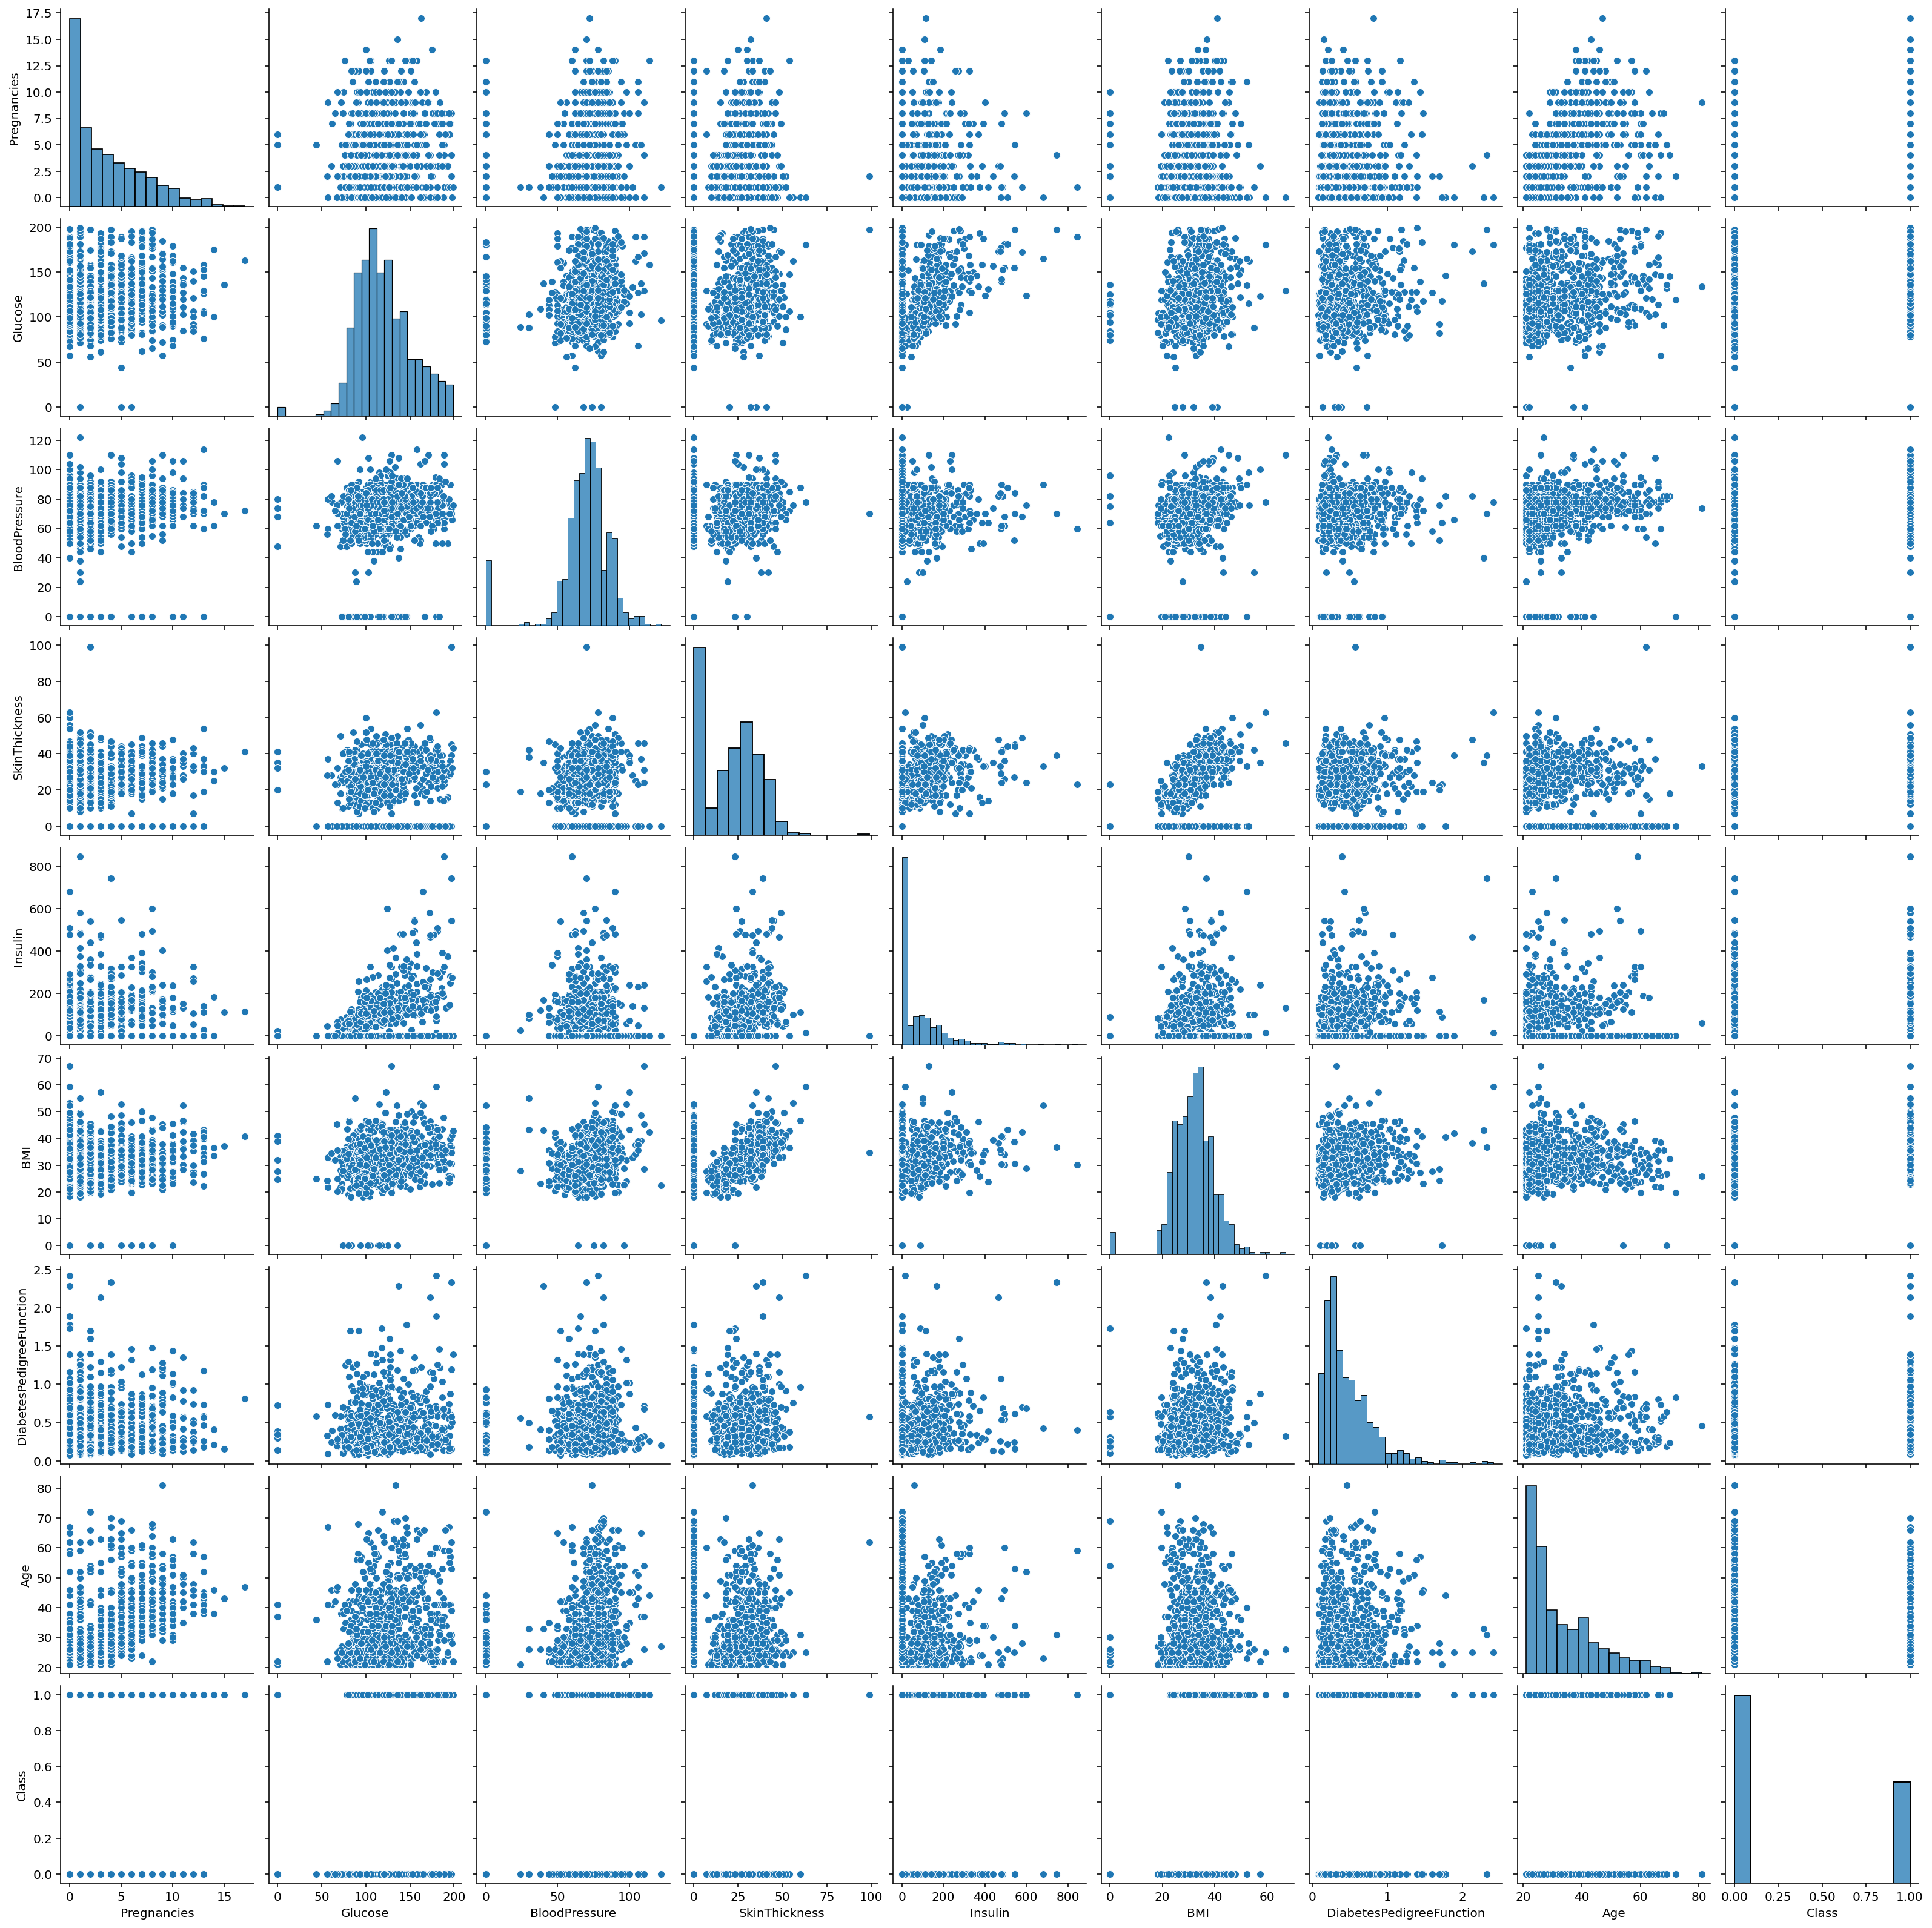

In [4]:
sns.pairplot(df);#,height=2.3,aspect=1.2);

### Dataset a bit imbalanced as there are half more 0s than 1s:

0    500
1    268
Name: Class, dtype: int64

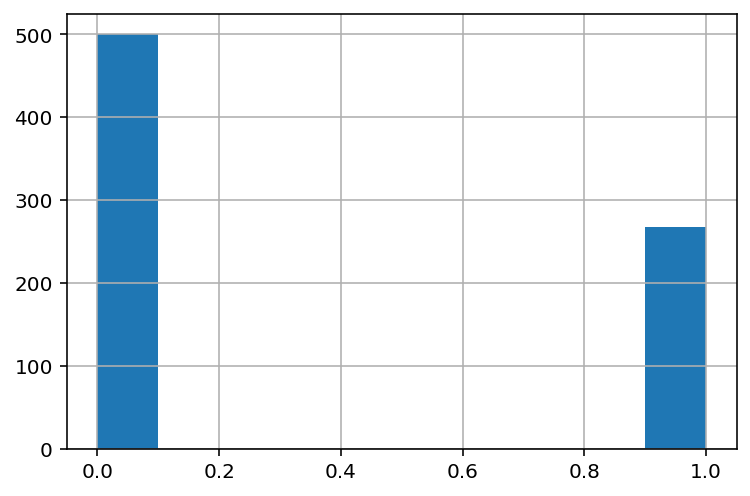

In [5]:
df['Class'].hist();
df['Class'].value_counts()

### However, Up-sampling and Down-sampling aren't helping here in this case:

In [6]:
# from sklearn.utils import resample

# # Separate majority and minority classes
# df_majority = df[df['Class']==0]
# df_minority = df[df['Class']==1]
 
# # # Upsample minority class
# # df_minority_upsampled = resample(df_minority, 
# #                                  replace=True,                            # sample with replacement
# #                                  n_samples=int(len(df[df['Class']==0])),  # to match majority class
# #                                  random_state=123)                        # reproducible results

# # # Combine majority class with upsampled minority class
# # df = pd.concat([df_majority, df_minority_upsampled])



# # Downsample majority class
# df_majority_downsampled = resample(df_majority, 
#                                  replace=False,                          # sample without replacement
#                                  n_samples=int(len(df[df['Class']==1])), # to match minority class
#                                  random_state=42)   #123                 # reproducible results

# # Combine minority class with downsampled majority class
# df = pd.concat([df_majority_downsampled, df_minority])
 
# # Display new class counts
# df['Class'].value_counts()

### Normalise and change type to float:

In [7]:
for i in df.columns:
    if i != 'Class':
        df[i+'_norm'] = [float((x-min(df[i]))/(max(df[i])-min(df[i]))) for x in df[i]]
df['Class'] = df['Class'].astype(float)
df.head(3)

Pregnancies  Glucose  BloodPressure  SkinThickness  Insulin   BMI  \
0            6      148             72             35        0  33.6   
1            1       85             66             29        0  26.6   
2            8      183             64              0        0  23.3   

   DiabetesPedigreeFunction  Age  Class  Pregnancies_norm  Glucose_norm  \
0                     0.627   50    1.0          0.352941      0.743719   
1                     0.351   31    0.0          0.058824      0.427136   
2                     0.672   32    1.0          0.470588      0.919598   

   BloodPressure_norm  SkinThickness_norm  Insulin_norm  BMI_norm  \
0            0.590164            0.353535           0.0  0.500745   
1            0.540984            0.292929           0.0  0.396423   
2            0.524590            0.000000           0.0  0.347243   

   DiabetesPedigreeFunction_norm  Age_norm  
0                       0.234415  0.483333  
1                       0.116567  0.166667  
2                       0.253629  0.183333

### Using PCA just to reduce the dimensionality and visualise it:

In [8]:
### Principal Component Analysis
from sklearn.decomposition import PCA

pca = PCA(3)
pca.fit(df[[x for x in df.columns if '_norm' in x ]])
pca_data = pd.DataFrame(pca.transform(df[[x for x in df.columns if '_norm' in x ]]))
# print(len(pca_data))
pca_data['Class'] = df['Class']
pca_data.head(2)

0         1         2  Class
0  0.304955  0.090382 -0.020112    1.0
1 -0.193298 -0.072952  0.127663    0.0

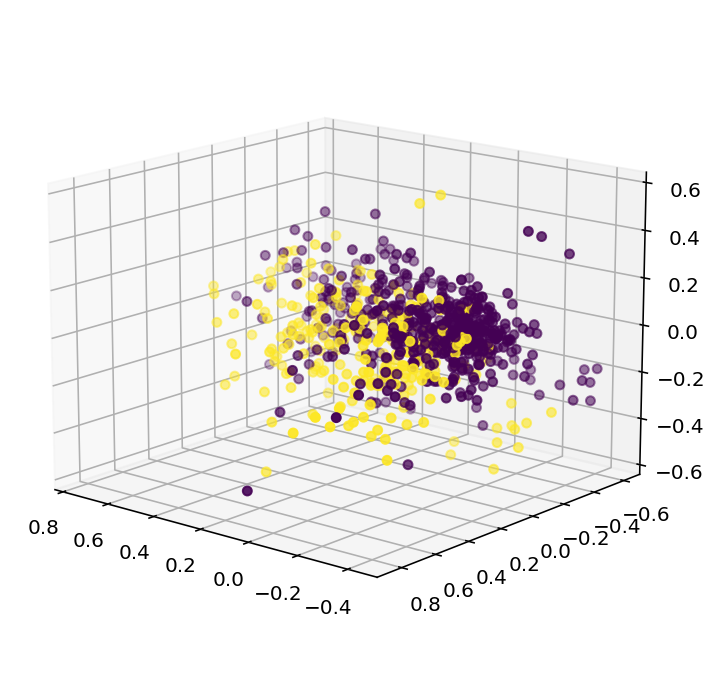

In [9]:
## 2 features
# plt.scatter(pca_data[0],pca_data[1],alpha=1,c=pca_data['Class'])

## 3 features
fig = plt.figure(figsize=(6,6))
ax = plt.axes(projection='3d')
ax.view_init(15, 130)
ax.scatter3D(pca_data[0],pca_data[1], pca_data[2], c=pca_data['Class']);

### Identify the features that have more impact to predict the target: 'Class'

In [10]:
#import libraries
from sklearn.svm import SVC
from sklearn.model_selection import StratifiedKFold
from sklearn.feature_selection import RFECV
import matplotlib.pyplot as plt#Fit the model

X, y = df[[x for x in df.columns if '_norm' in x]], df['Class']


svc = SVC(kernel="linear")

rfecv = RFECV(estimator=svc, step=1, cv=StratifiedKFold(2), scoring='accuracy')
rfecv.fit(X, y)

print(X.columns[rfecv.get_support()])
print("Optimal number of features : {}".format(rfecv.n_features_))

Index(['Pregnancies_norm', 'Glucose_norm', 'BloodPressure_norm', 'BMI_norm',
       'DiabetesPedigreeFunction_norm', 'Age_norm'],
      dtype='object')
Optimal number of features : 6


In [11]:
# df.columns

### Functions for stochastic gradient descent, Logistic regression, etc...

In [12]:
from sklearn.metrics import confusion_matrix, accuracy_score

# Make a prediction with coefficients
def predict(row, coefficients):
    yhat = coefficients[0]
    for i in range(len(row)-1):
        yhat += coefficients[i + 1] * row[i]
    return 1.0 / (1.0 + exp(-yhat))

# Estimate logistic regression coefficients using stochastic gradient descent
def coefficients_sgd(train, l_rate, n_epoch):
    coef = [0.0 for i in range(len(train.columns))]
    for epoch in range(n_epoch):
        for _,row in train.iterrows():
            yhat = predict(list(row), coef)
            error = row[-1] - yhat
            coef[0] = coef[0] + l_rate * error * yhat * (1.0 - yhat)
            for i in range(len(row)-1):
                coef[i + 1] = coef[i + 1] + l_rate * error * yhat * (1.0 - yhat) * row[i]
    return coef

# Logistic Regression Algorithm using Stochastic Gradient Descent:
def logistic_regression(train, test, l_rate, n_epoch):
    predictions = []
    coef = coefficients_sgd(train, l_rate, n_epoch)
    for _,row in test.iterrows():
        yhat = round(predict(list(row), coef))
        predictions.append(yhat)
    return(predictions)

# Calculate accuracy:
def accuracy_metric(actual, predicted):
    correct = 0
    for i in range(len(actual)):
        if actual[i] == predicted[i]:
            correct += 1
    return correct / float(len(actual)) * 100.0

def null_accuracy(actual):
    the_most = df['Class'].median()
    prediction = [the_most for i in range(len(actual))]
    null_acc = accuracy_score(actual, prediction)*100
    return null_acc

### Model:

fold 0   Accuracy: 76.172% , Null accuracy: 61.719%
fold 1   Accuracy: 73.438% , Null accuracy: 66.016%
fold 2   Accuracy: 80.859% , Null accuracy: 67.578%
Mean Accuracy: 76.823%, Mean Null Accuracy: 65.104%


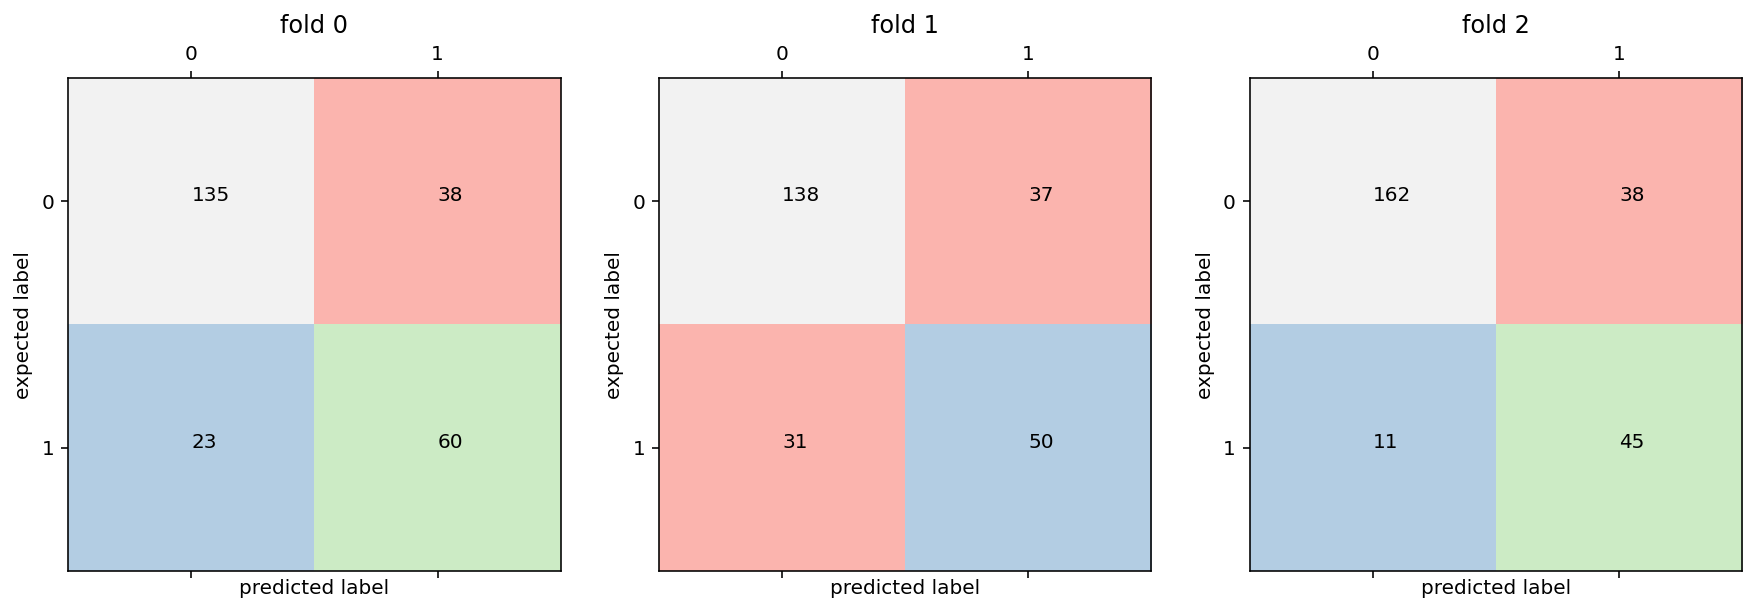

In [13]:
from math import exp

# parameters:
n_folds = 3
l_rate = 0.1
n_epoch = 150

fig,ax=plt.subplots(1,n_folds,figsize=(15,5))

### Cross validation split:
# folds = np.array_split(df[[x for x in df.columns if '_norm' in x]+['Class']], n_folds)

folds = np.array_split(df[list(X.columns[rfecv.get_support()])+['Class']], n_folds)

### Evaluate algorithm:
scores = []
scores_null = []
for _,fold in enumerate(folds):
    ## Remove the fold from the training set:
    train_set = pd.concat(folds+[fold]).drop_duplicates(keep=False)
    ## and use it as test set:
    test_set = fold
    
    ## predict:
    predicted = logistic_regression(train_set, test_set, l_rate, n_epoch)
    actual = fold['Class'].to_list()
    accuracy = accuracy_metric(actual, predicted)
    scores.append(accuracy)
    
    ## plot:
    confuse = confusion_matrix(actual, predicted)
    ax[_].matshow(confuse, cmap='Pastel1')
    for x in range(0, 2):
        for y in range(0, 2):
            ax[_].text(x,y, confuse[x,y])
        
    ax[_].set_ylabel('expected label')
    ax[_].set_xlabel('predicted label')
    ax[_].set_title('fold {}'.format(_))
    
    ## null accuracy
    null_ = null_accuracy(actual)
    scores_null.append(null_)
    print('fold {}   Accuracy: {:5}% , Null accuracy: {:5}%'.format(_,np.round(accuracy,3),np.round(null_,3)))

# print('Scores: {}'.format(scores))
print('Mean Accuracy: {:.3f}%, Mean Null Accuracy: {:.3f}%'.format(sum(scores)/float(len(scores)),sum(scores_null)/float(len(scores_null))))

- Null accuracy is the accuracy that could be achieved by always predicting the most frequent class. **This means that a model that always predicts 0 would be right 65.1% of the time. Not great...** That's why classification accuracy isn't the best method to compare different models. Confusion matrix is a better example.

## Comparison with Tensorflow:

### Split the dataset bewteen a training set and a test set:

In [14]:
# train, test = np.split(df[[x for x in df.columns if '_norm' in x]+['Class']].sample(frac=1, random_state=42), [int(.8*len(df))])

train, test = np.split(df[['Pregnancies_norm', 'Glucose_norm', 'BloodPressure_norm', 
                           'BMI_norm','DiabetesPedigreeFunction_norm', 'Age_norm']+['Class']].sample(frac=1, random_state=42), [int(.8*len(df))])

print(train.shape[0],test.shape[0])

614 154


### Split the features from the target:

In [15]:
train_X = train[train.columns[:-1]].reset_index(drop=True)
train_y = train['Class'].reset_index(drop=True)
test_X = test[test.columns[:-1]].reset_index(drop=True)
test_y = test['Class'].reset_index(drop=True)

train_X.head(2)

Pregnancies_norm  Glucose_norm  BloodPressure_norm  BMI_norm  \
0          0.352941      0.492462            0.475410  0.506706   
1          0.117647      0.562814            0.614754  0.532042   

   DiabetesPedigreeFunction_norm  Age_norm  
0                       0.150299  0.366667  
1                       0.029889  0.000000

In [16]:
# import tensorflow as tf

import tensorflow.compat.v1 as tf
tf.disable_v2_behavior()

INFO:tensorflow:Enabling eager execution
INFO:tensorflow:Enabling v2 tensorshape
INFO:tensorflow:Enabling resource variables
INFO:tensorflow:Enabling tensor equality
INFO:tensorflow:Enabling control flow v2
INFO:tensorflow:Disabling eager execution
INFO:tensorflow:Disabling v2 tensorshape
Instructions for updating:
non-resource variables are not supported in the long term
INFO:tensorflow:Disabling resource variables
INFO:tensorflow:Disabling tensor equality
INFO:tensorflow:Disabling control flow v2


### Building the model framework

In [17]:
# Declare the variables that need to be learned and initialization
A = tf.Variable(tf.random_normal(shape=[len(train_X.columns), 1]))
b = tf.Variable(tf.random_normal(shape=[1, 1]))
init = tf.global_variables_initializer()
sess = tf.Session()
sess.run(init)

In [18]:
# Define placeholders
data = tf.placeholder(dtype=tf.float32, shape=[None, len(train_X.columns)])
target = tf.placeholder(dtype=tf.float32, shape=[None, 1])

In [19]:
# Declare the model to learn
mod = tf.matmul(data, A) + b

In [20]:
# Declare loss function
# Use the sigmoid cross-entropy loss function,
# first doing a sigmoid on the model result and then using the cross-entropy loss function
loss = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=mod, labels=target))

In [21]:
# Define the learning rateï¼Œbatch_size and iter_num
learning_rate = 0.8
batch_size = 500
iter_num = 1500

In [22]:
# Define the optimizer
opt = tf.train.GradientDescentOptimizer(learning_rate)

In [23]:
# Define the goal
goal = opt.minimize(loss)

In [24]:
# Define the accuracy
# The default threshold is 0.5, rounded off directly
prediction = tf.round(tf.sigmoid(mod))
# Bool into float32 type
correct = tf.cast(tf.equal(prediction, target), dtype=tf.float32)
# Average
accuracy = tf.reduce_mean(correct)
# End of the definition of the model framework

In [25]:
# confuse = tf.math.confusion_matrix(target, prediction, num_classes=None, weights=None, dtype=tf.dtypes.int32,name=None)

In [26]:
# Start training model
# Define the variable that stores the result
loss_trace = []
train_acc = []
test_acc = []

### Model training

In [27]:
# training model
for epoch in range(iter_num):
    # Generate random batch index
    batch_index = np.random.choice(len(train_X), size=batch_size)
    batch_train_X = train_X.iloc[batch_index]
    batch_train_y = np.matrix(train_y[batch_index]).T
    sess.run(goal, feed_dict={data: batch_train_X, target: batch_train_y})
    temp_loss = sess.run(loss, feed_dict={data: batch_train_X, target: batch_train_y})
    # convert into a matrix, and the shape of the placeholder to correspond
    temp_train_acc = sess.run(accuracy, feed_dict={data: train_X, target: np.matrix(train_y).T})
    temp_test_acc = sess.run(accuracy, feed_dict={data: test_X, target: np.matrix(test_y).T})
    # recode the result
    loss_trace.append(temp_loss)
    train_acc.append(temp_train_acc)
    test_acc.append(temp_test_acc)
    # output
    if (epoch + 1) % 300 == 0:
        print('epoch: {:4d} loss: {:5f} train_acc: {:5f} test_acc: {:5f}'.format(epoch + 1, temp_loss,temp_train_acc, temp_test_acc))

epoch:  300 loss: 0.506536 train_acc: 0.773616 test_acc: 0.746753
epoch:  600 loss: 0.476268 train_acc: 0.785016 test_acc: 0.753247
epoch:  900 loss: 0.462091 train_acc: 0.786645 test_acc: 0.746753
epoch: 1200 loss: 0.462511 train_acc: 0.785016 test_acc: 0.740260
epoch: 1500 loss: 0.459262 train_acc: 0.781759 test_acc: 0.740260


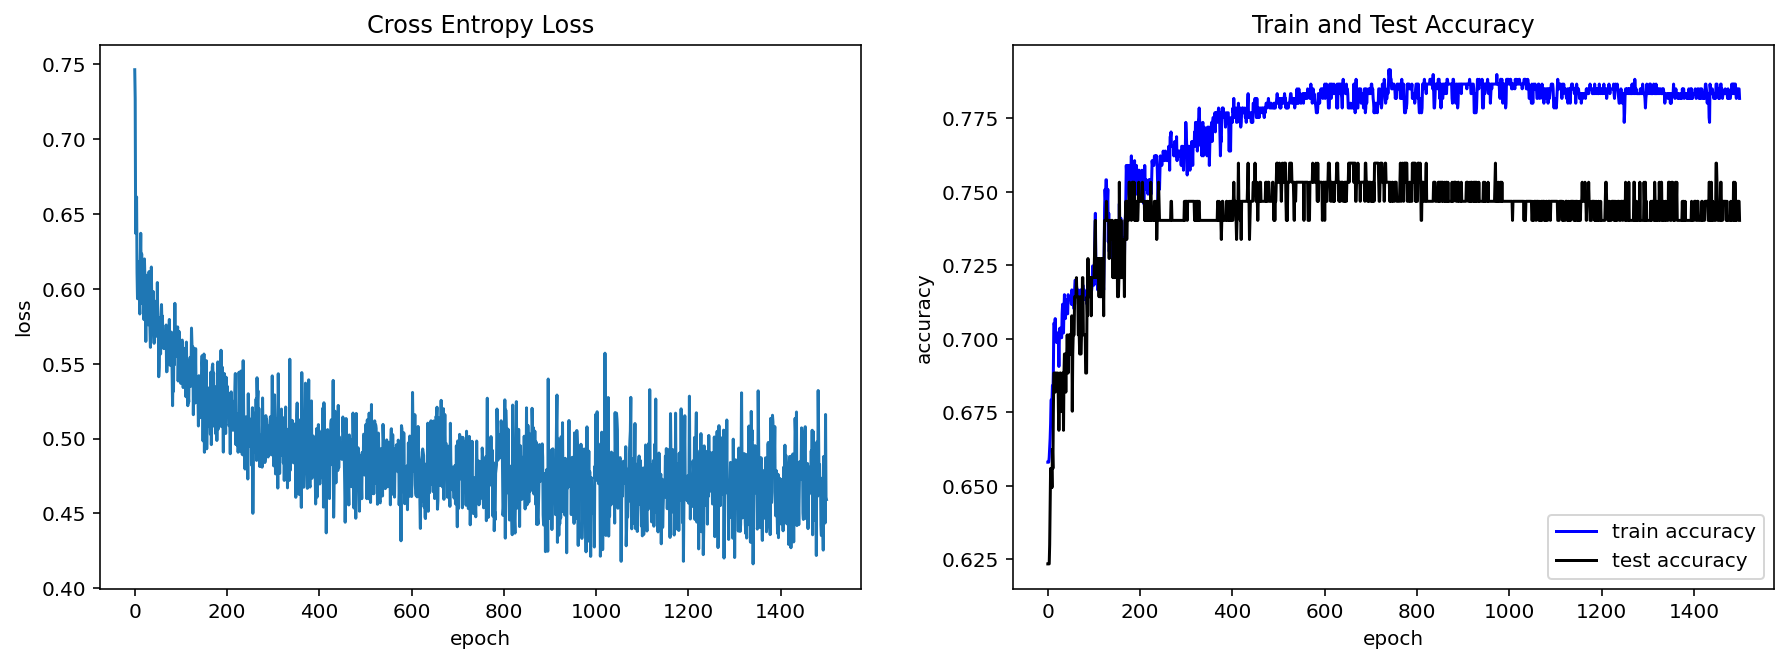

In [28]:
fig,ax=plt.subplots(1,2,figsize=(15,5))

# Visualization of the results
# loss function
ax[0].plot(loss_trace)
ax[0].set_title('Cross Entropy Loss')
ax[0].set_xlabel('epoch')
ax[0].set_ylabel('loss')

# accuracy
ax[1].plot(train_acc, 'b-', label='train accuracy')
ax[1].plot(test_acc, 'k-', label='test accuracy')
ax[1].set_xlabel('epoch')
ax[1].set_ylabel('accuracy')
ax[1].set_title('Train and Test Accuracy')
ax[1].legend(loc='best');

### The difference isn't massive but Tensorflow is just so much faster.

graph for map:

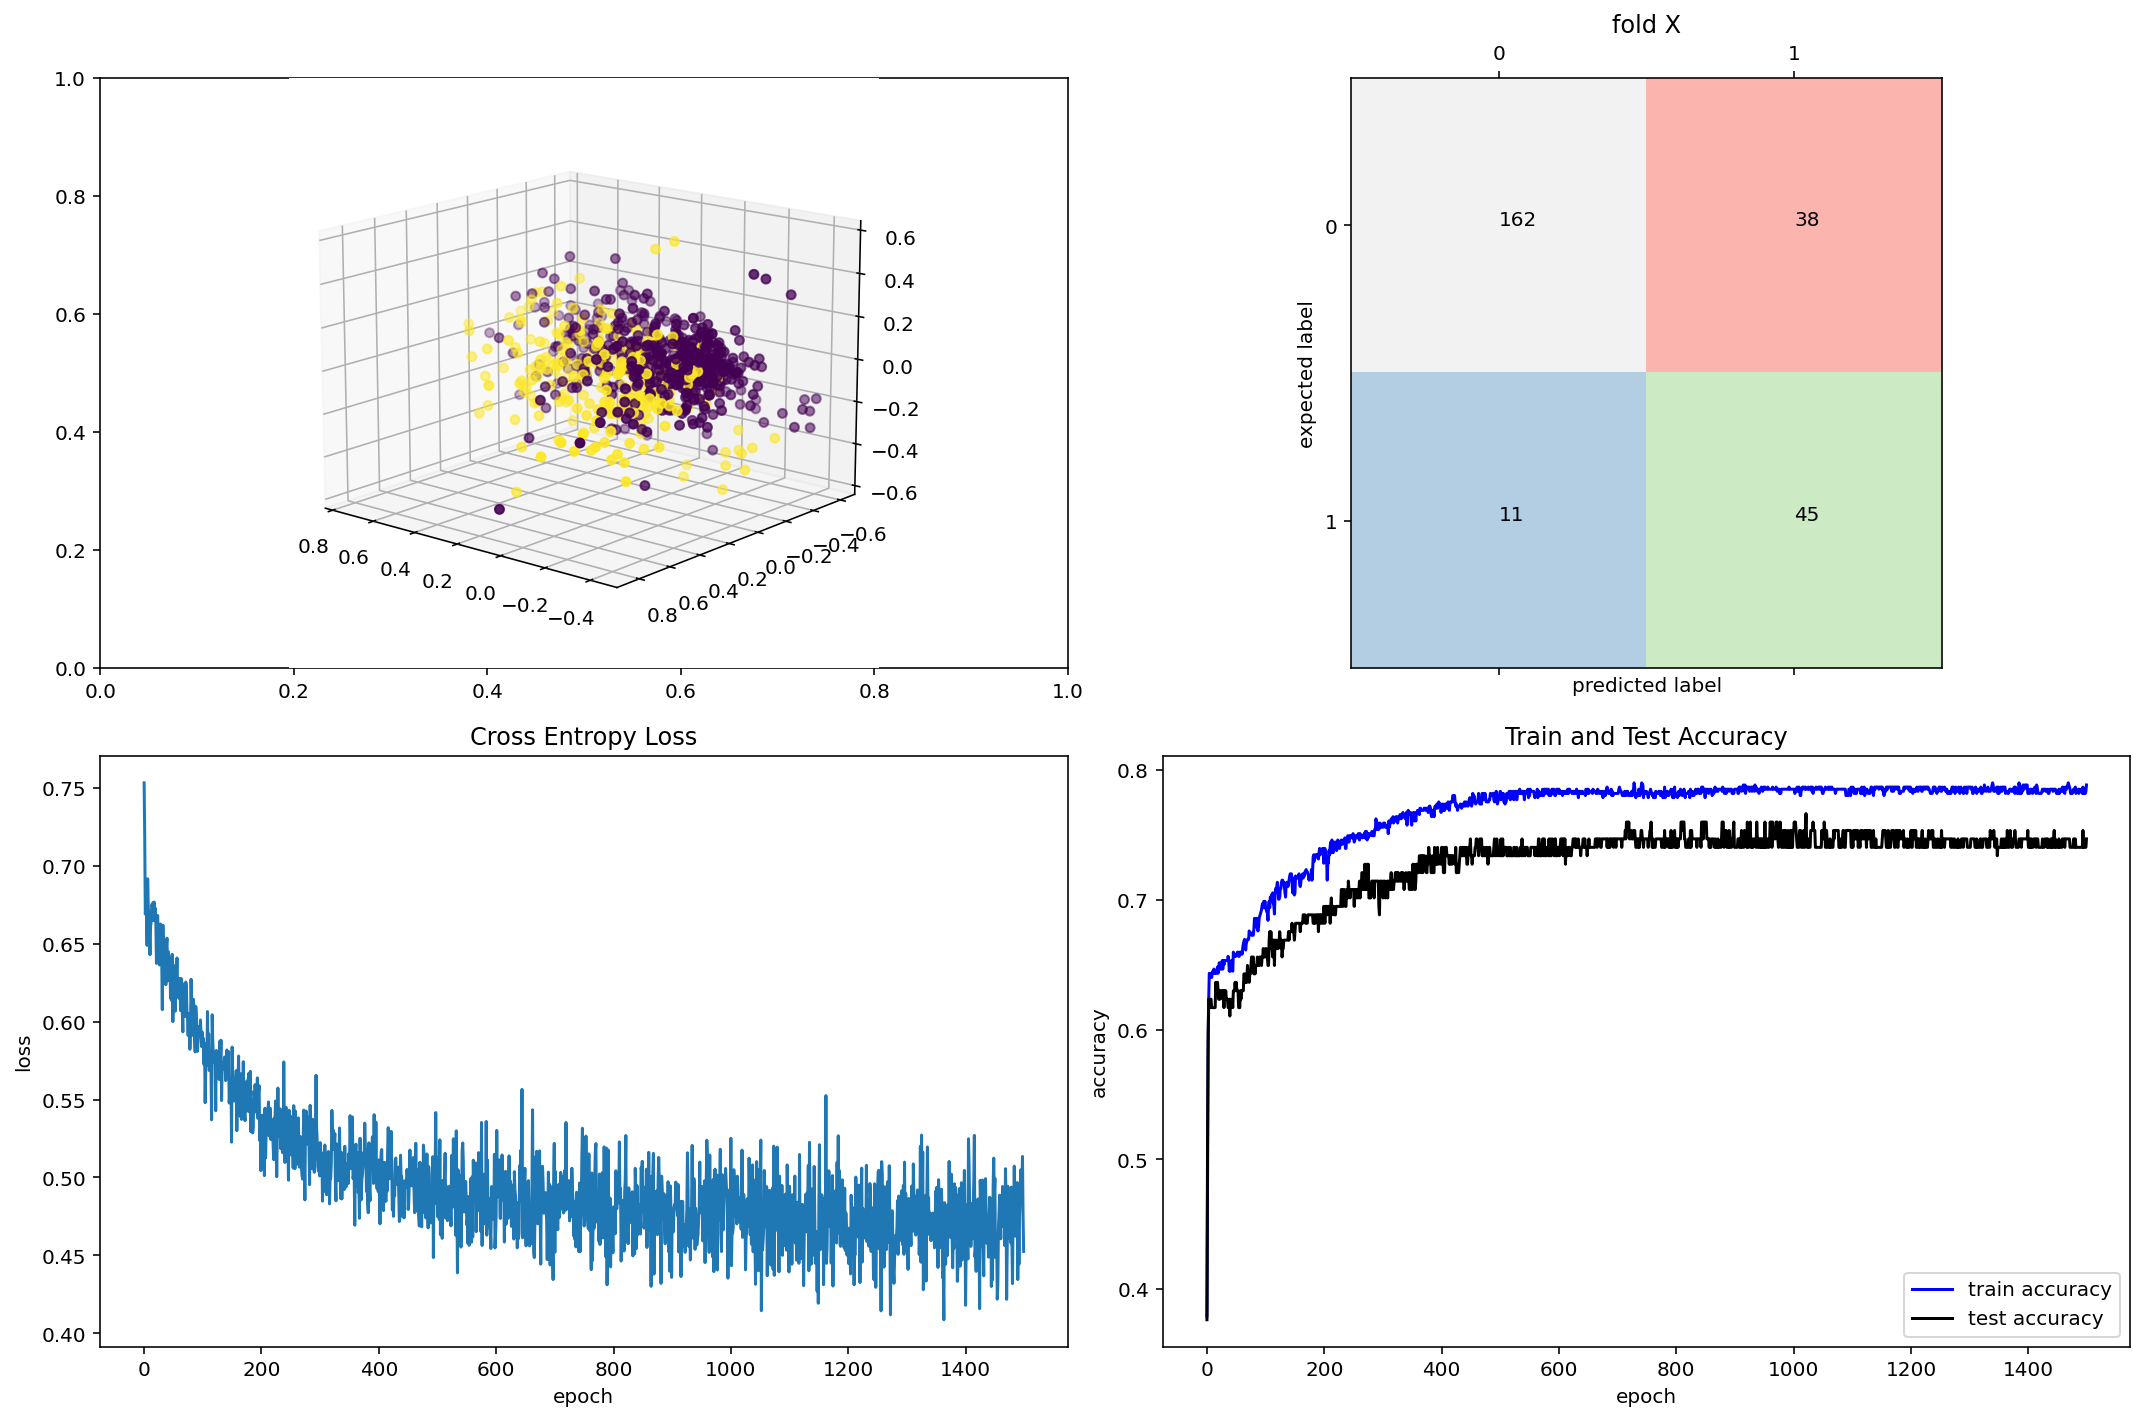

In [54]:
fig, ax = plt.subplots(2,2,figsize=(15,10))


ax[0,0] = fig.add_subplot(2, 2, 1, projection='3d')
# ax[0,0].axes(projection='3d')
ax[0,0].view_init(15, 130)
ax[0,0].scatter3D(pca_data[0],pca_data[1], pca_data[2], c=pca_data['Class']);


# confuse = confusion_matrix(actual, predicted)
confuse = confusion_matrix(actual, predicted)
ax[0,1].matshow(confuse, cmap='Pastel1')
for x in range(0, 2):
    for y in range(0, 2):
        ax[0,1].text(x,y, confuse[x,y])
        
ax[0,1].set_ylabel('expected label')
ax[0,1].set_xlabel('predicted label')
ax[0,1].set_title('fold X')

# Visualization of the results
# loss function
ax[1,0].plot(loss_trace)
ax[1,0].set_title('Cross Entropy Loss')
ax[1,0].set_xlabel('epoch')
ax[1,0].set_ylabel('loss')

# accuracy
ax[1,1].plot(train_acc, 'b-', label='train accuracy')
ax[1,1].plot(test_acc, 'k-', label='test accuracy')
ax[1,1].set_xlabel('epoch')
ax[1,1].set_ylabel('accuracy')
ax[1,1].set_title('Train and Test Accuracy')
ax[1,1].legend(loc='best');

plt.tight_layout()
plt.savefig('Diabetes Logistic Regression.png', dpi=500,transparent=False)
plt.show()